In [1]:
from ndreg import *
import tempfile, os, fnmatch, shutil
%matplotlib inline

# 3D STP Registration
In this tutorial we show how to register Serial Two Photon Tomography images to the ARA.

## Downloading ARA 
First we'll download the Allen Reference Atlas (ARA) and associated annotations

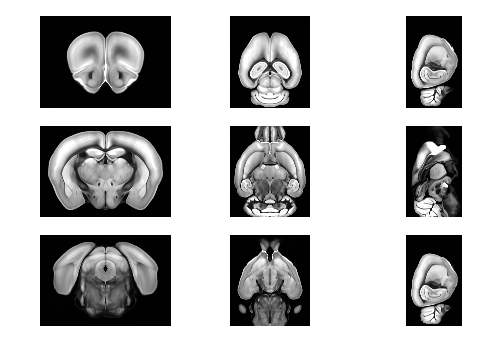

In [2]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)
imgShow(refImg,vmax=500)

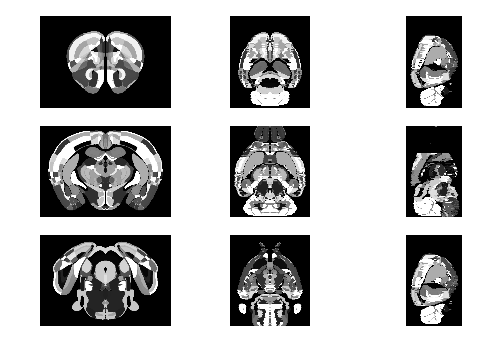

In [3]:
refAnnoImg = imgDownload(refToken, channel="annotation")
imgShow(refAnnoImg, vmax=1000)

## Downloading STP Tomography image
Next we'll download the input STP Tomography image.  The STP image has several channels.

In [4]:
inToken="eacker01"
nd = neurodata()
print(nd.get_channels(inToken).keys())

[u'r', u'b', u'annotation2', u'rgb', u'g']


The STP data was acquired in color and is stored in the **rgb** channel.  The **r**, **g** and **b** store ther red, green and blue channels respectively. The input STP data also has 5 resolution levels available. 

In [5]:
print(nd.get_metadata(inToken)['dataset']['voxelres'].keys())

[u'1', u'0', u'3', u'2', u'5', u'4']


Since the **r** channel contains the most information while level **5** is the lowest possible resolution we'll download it using these parameters

In [6]:
inImg = imgDownload(inToken,"r",5)

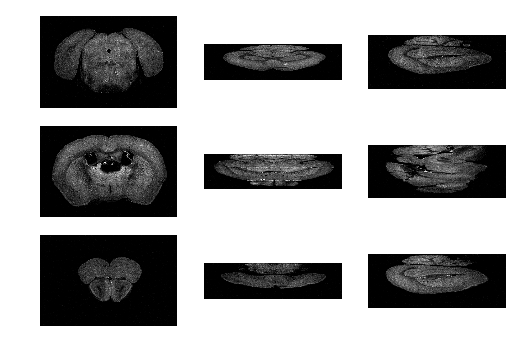

In [7]:
imgShow(inImg, vmax=10000)

## Reorienting STP Tomography image
Clearly the downloaded input image is not oriented in the same way as the reference image.  The input image is in **lsp** orientation while the reference image is in **rsa** orientation.  Thue we need to reorient the input image.

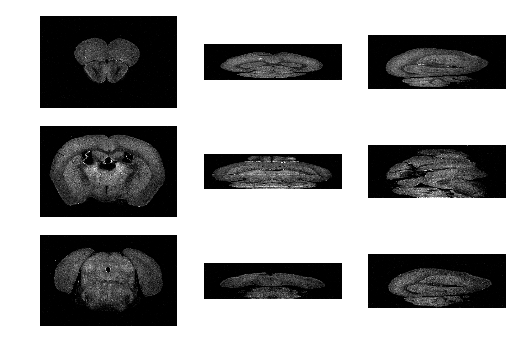

In [8]:
inImg = imgReorient(inImg, "lsp", "rsa")
imgShow(inImg, vmax=10000)

## Resampling images
At their current resolutions, registering these images would be way to computationally expensive for the purposes of this tutorial.

In [9]:
print(inImg.GetSize())
print(inImg.GetSpacing())

(574, 384, 150)
(0.032, 0.032, 0.09999999999999999)


In [10]:
print(refImg.GetSize())
print(refImg.GetSpacing())

(456, 320, 528)
(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


Thus we'll downsample them to 0.25 mm x 0.25 mm x 0.25 mm

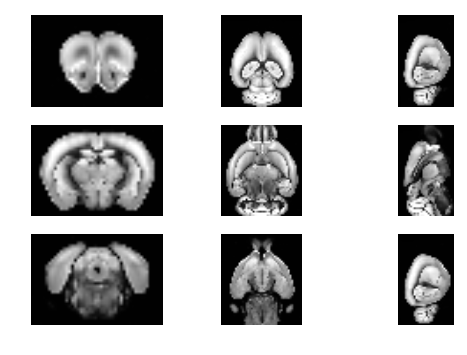

In [11]:
spacing=[0.25,0.25,0.25]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=500)

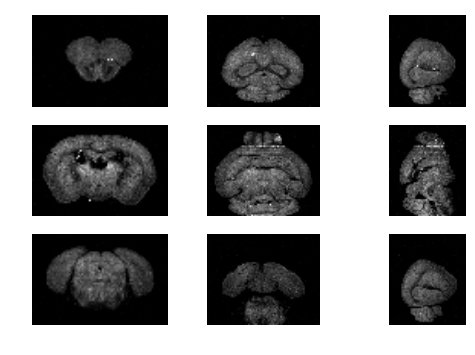

In [12]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=10000)

## Affine Registraton
Now we'll run affine registration

In [13]:
affine = imgAffineComposite(inImg_ds, refImg_ds, iterations=200, useMI=True, verbose=False)

Next we'll apply the affine transform to the input image

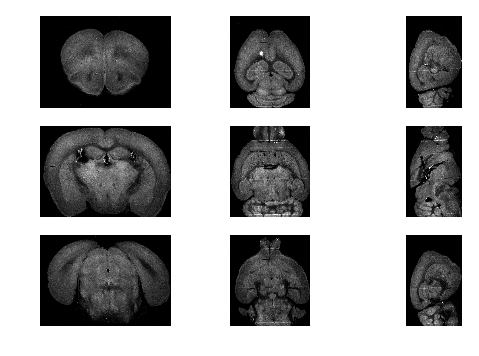

In [14]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_affine, vmax=10000)

## LDDMM Registration
Since we want a copies of the LDDMM log files we'll write the results to a temporary directory. 

In [15]:
outDirPath = tempfile.mkdtemp() + "/"
print(outDirPath)

/tmp/tmpXHd5V2/


Now we'll run LDDMM registration while writing the log files to the temporary directory. This will take 5 to 15 minutes.

In [16]:
inImg_ds = imgResample(inImg_affine, spacing=spacing)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds,
                                              alphaList=[0.05, 0.02, 0.01],
                                              useMI=True,
                                              iterations=100,
                                              outDirPath=outDirPath,
                                              verbose=False)
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize(), spacing=refImg.GetSpacing())

## Displaying Results
We can easly display the registration results using the following function.

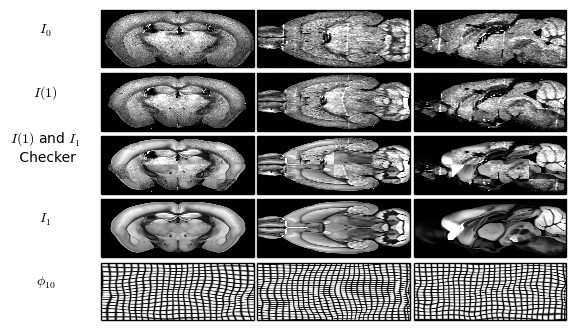

In [17]:
imgMetamorphosisSlicePlotter(inImg_affine, refImg, field)

Likewise we can display the iteration results using the log files.  First we make a list of these files

In [18]:
logPathList = []
for root, dirnames, filenames in os.walk(outDirPath):
    for filename in fnmatch.filter(filenames, 'log.txt'):
        logPathList.append(os.path.join(root, filename))
logPathList.sort()
print(logPathList)

['/tmp/tmpXHd5V2/step0/log.txt', '/tmp/tmpXHd5V2/step1/log.txt', '/tmp/tmpXHd5V2/step2/log.txt']


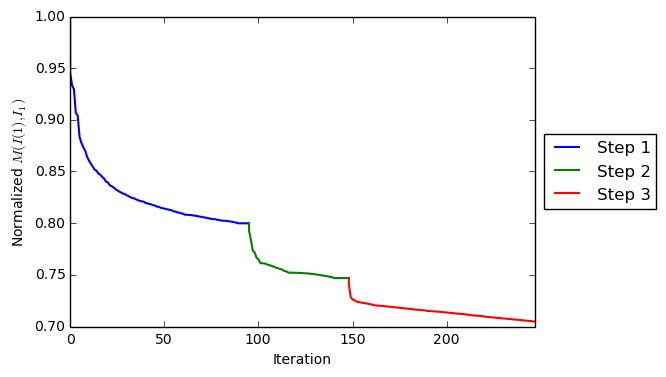

In [19]:
imgMetamorphosisLogPlotter(logPathList)

Let's clean up be deleting the temporary output directory

In [20]:
shutil.rmtree(outDirPath)